In [1]:
# Import modules

# import urllib

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [4]:
# video = YouTubeVideo("XkJCvtCRdVM", width=1024, height=640)
# display(video)

In [5]:
video_input_file_name = "race_car.mp4"


def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

In [7]:
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]
print(cv2.__version__)

# Change the index to change the tracker type
tracker_type = tracker_types[6]

# Correct tracker creation for OpenCV 4.11.0
if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting_create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL_create()
elif tracker_type == "KCF":
    tracker = cv2.legacy.TrackerKCF_create()
elif tracker_type == "CSRT":
    tracker = cv2.legacy.TrackerCSRT_create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD_create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow_create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN_create()
elif tracker_type == "MOSSE":
    tracker = cv2.legacy.TrackerMOSSE_create()
else:
    raise ValueError(f"Invalid tracker type: {tracker_type}")

print(f"{tracker_type} tracker created successfully.")

4.11.0
GOTURN tracker created successfully.


In [8]:
# Read video
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = "race_car-" + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


'race_car-GOTURN.mp4'

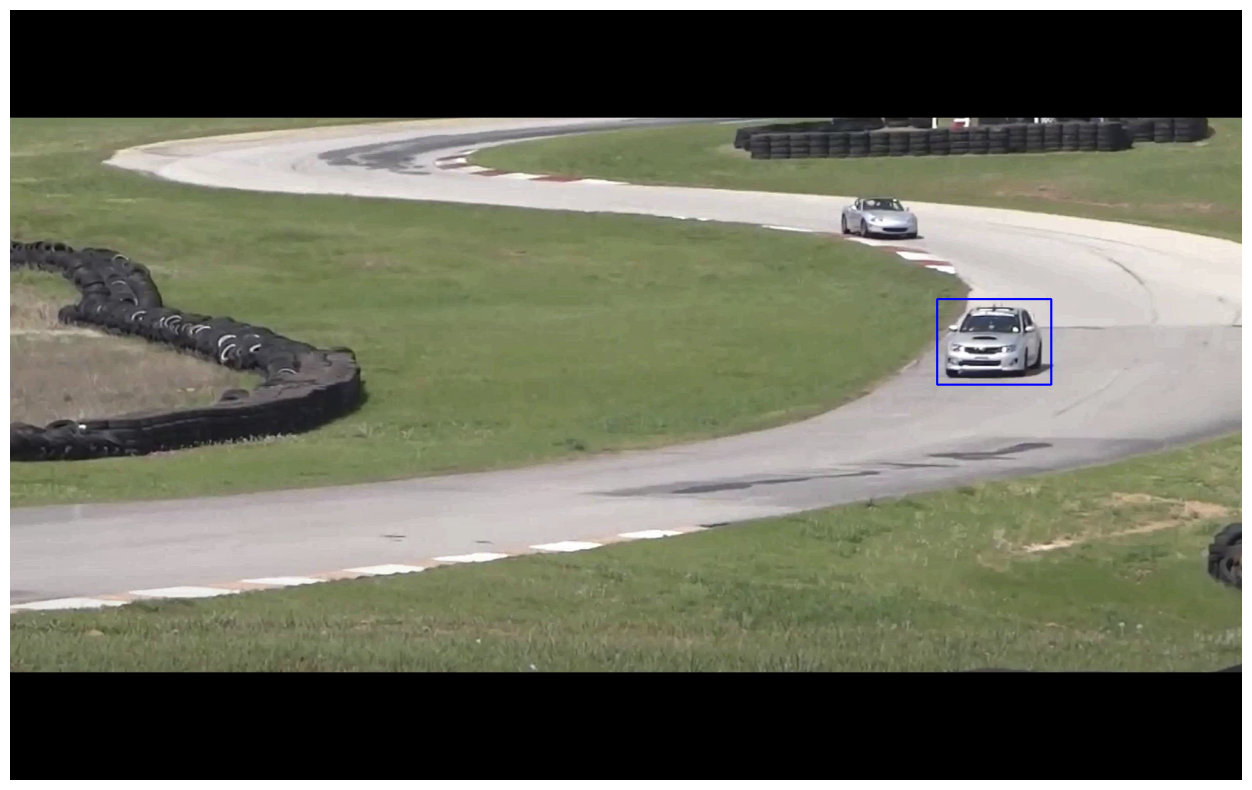

In [9]:
# Define a bounding box
bbox = (1300, 405, 160, 120)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame, bbox)

In [10]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)

In [11]:
while True:
    ok, frame = video.read()

    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else:
        drawText(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80, 60))
    drawText(frame, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame)

video.release()
video_out.release()

In [12]:
# Installing ffmpeg
# !apt-get -qq install ffmpeg

# Change video encoding of mp4 file from XVID to h264
!ffmpeg -y -i {video_output_file_name} -c:v libx264 "race_car_track_x264.mp4"  -hide_banner -loglevel error

In [13]:
mp4 = open("race_car_track_x264.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""<video width=1024 controls><source src="{data_url}" type="video/mp4"></video>""")